# Imports

In [30]:
# For data analysis
import numpy as np
import pandas as pd

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# For outlier capping
from scipy.stats.mstats import winsorize
import scipy.stats as stats  # Import statistical functions - used for Chi-Square

# For text pattern matching
import re

# For preprocessing
from sklearn.model_selection import train_test_split # For splitting the data into training/validation/test sets
from sklearn.pipeline import Pipeline # To create a sequential workflow of preprocessing steps
from sklearn.compose import ColumnTransformer # For applying different transformations to different columns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler # To encode categorical variables and scale numeric features

# For modeling
from sklearn.linear_model import Lasso #Lasso estimator for fitting an L1‐regularized linear model
from sklearn.model_selection import GridSearchCV, cross_val_score # to tune hyper parameters
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score #evaluation metrics
from sklearn.ensemble import RandomForestRegressor # Random Forest regressor

## Data

In [2]:
cost_of_living = pd.read_csv("C:/Users/barbe/OneDrive/DS Projects/Cost of Living Prediction/cost_of_living_us.csv")

# Cleaning Data

In [3]:
# Drop missing values
cost_of_living = cost_of_living.dropna(subset=['median_family_income'])

# Convert all object columns to category
for col in cost_of_living.select_dtypes(include=['object']).columns:
    cost_of_living[col] = cost_of_living[col].astype('category')

# select numerical columns
num_cols = cost_of_living.select_dtypes(include=['number']).columns

#define function to identify outliers via IQR
def identify_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

#create dataframe to store outliers
outliers_df = pd.DataFrame()

#apply function to numerical variables
#iterate over variables
for var in num_cols:
    outliers = identify_outliers(cost_of_living, var)
    #concatenate outliers to outlier dataframe
    outliers_df = pd.concat([outliers_df, outliers])

#drop duplicate rows since some rows may be outliers in multiple columns
outliers_df = outliers_df.drop_duplicates()

# Define a function to cap outliers
def cap_outliers(data, column, lower_pct=0.05, upper_pct=0.95):
    data[column] = winsorize(data[column], limits=(lower_pct, 1-upper_pct))
    return data

# Apply the function to all numerical columns
for var in num_cols:
    col_clean = cap_outliers(cost_of_living, var)

# Function to extract parent and child counts
def extract_family_counts(family_str):
    if isinstance(family_str, str):  # Ensure the input is a string
        match = re.match(r'(\d+)p(\d+)c', family_str)  # Regex to extract numbers before 'p' and 'c'
        if match:
            num_parents = int(match.group(1))  # Extract parent count
            num_children = int(match.group(2))  # Extract child count
        else:
            num_parents, num_children = 0, 0  # Default for unexpected formats
    else:
        num_parents, num_children = 0, 0  # Handle non-string cases safely

    return num_parents, num_children

# Ensure 'family_member_count' is a string before applying the function
col_clean['family_member_count'] = col_clean['family_member_count'].astype(str)

# Apply function to create new columns
col_clean[['num_parents', 'num_children']] = col_clean['family_member_count'].apply(lambda x: pd.Series(extract_family_counts(x)))

# Create total family size column
col_clean['family_total'] = col_clean['num_parents'] + col_clean['num_children']

# Drop case_id and family_member_count columns
col_clean = col_clean.drop(columns=['case_id', 'family_member_count'])

# Master Preprocessing

## Feature Redundancy Removal

In [4]:
# List of features to drop
features_to_drop = ["county", "areaname", "num_children", "num_parents"]

# Remove unnecessary columns from the dataset
col_clean = col_clean.drop(columns=features_to_drop)

## Handling Skewed Numerical Features

In [5]:
# Apply natural log transformation to right-skewed features
skewed_features = ["housing_cost", "taxes", "median_family_income"]
for feature in skewed_features:
    col_clean[feature + "_log"] = np.log1p(col_clean[feature])  # log(1 + x) to handle zero values safely

# Drop the original skewed columns to avoid redundancy
col_clean = col_clean.drop(columns=skewed_features)

## Handling Boolean Features

In [6]:
# Convert boolean to binary (0/1)
col_clean["isMetro"] = col_clean["isMetro"].astype(int)

# Save the result as the “master” cleaned dataset
master_df = col_clean.copy()

# Regression Model Preprocessing

In [7]:
# Create a separate copy of master_df for the regression pipeline
df_reg = master_df.copy()   # df_reg will be used for regression-specific preprocessing and modeling

In [8]:
# Separate predictors and the target
X = df_reg.drop(columns=["total_cost"]) # X contains all predictor variables
y = df_reg["total_cost"] # Create a separate copy of master_df for the clustering pipeline

Split the data so that 70% Training, 20% Validation, 10% Testing

In [9]:
# Split the dataset: 70% for training and 30% for temporary (validation + test) set.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.70, random_state=12)

# Further split the temporary set into validation (20%) and test (10%) sets.
X_val, X_test, y_val, y_test = train_test_split( X_temp, y_temp, test_size=1/3, random_state=12)

In [10]:
# Identify the categorical and numeric features in the training data.
categorical_feats = ["state"] # List of categorical features: in this case only 'state' remains
numeric_feats = [col for col in X_train.columns if col not in categorical_feats]  # Every other column is numeric

Preprocessing:
- OneHotEncoder: encode the state categorical feature into dummy/binary columns, Dropping first category.
- StandardScaler: scale the numeric features (other than state) so they have zero mean and unit variance.
- ColumnTransformer: Combines these transformations, applying each to its respective set of columns.

In [11]:
# Build a ColumnTransformer to process different columns:
preprocessor = ColumnTransformer(
    transformers=[
        # OneHotEncode the 'state' column; drop the first category to avoid collinearity
        ("state_ohe", OneHotEncoder(drop="first"), categorical_feats),
        # Standardize the numeric features using StandardScaler
        ("num_scale", StandardScaler(), numeric_feats)
    ],
    remainder="drop"  # This ensures any columns not specified are dropped
)

The Pipeline encapsulates our preprocessing steps:
- Fit the transformations on training data.
- Apply the same learned transformations to validation and testing sets.

In [12]:
# Wrap the ColumnTransformer in a Pipeline so that we can sequentially call the preprocessing step
reg_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor)  # The pipeline consists solely of our preprocessor
])

In [13]:
# Fit the pipeline on the training data and transform the training set.
X_train_prep = reg_pipeline.fit_transform(X_train, y_train)

# Apply the fitted pipeline to transform the validation set.
X_val_prep = reg_pipeline.transform(X_val)

# Apply the same transformation to the test set.
X_test_prep = reg_pipeline.transform(X_test)

We are now ready for regression modeling!

# Regression Modeling

## Regression Model Selection

Here are the regression models we’ll use, along with why each is well suited to the housing-cost dataset:

**Lasso Regression**  
- Lasso applies an L1 penalty that pushes many coefficients to exactly zero, which helps simplify the model by automatically selecting only the most informative predictors—ideal for the dataset’s dozens of features (log-transformed costs, one-hot state dummies, etc.).

**Random Forest Regressor**  
- Random Forest captures non-linear interactions without having to hand-craft interaction terms. It's robust to remaining outliers, handles mixed numeric/categorical inputs seamlessly, and provides feature-importance metrics so we can see which factors drive most of the variance in total_cost.  

## Lasso Regression

In [17]:
# Define Lasso regressor
lasso = Lasso(max_iter=5000, random_state=42)

# Define parameter grid
param_grid = {"alpha": [0.001, 0.01, 0.1, 1.0, 10.0]}  # span from light to heavy regularization

In [18]:
# Create GridSearchCV to find the best alpha
grid_search = GridSearchCV(
    estimator=lasso,                                # the base Lasso model
    param_grid=param_grid,                          # hyperparameters to search
    cv=10,                                           # split training data into 10 folds
    scoring="neg_root_mean_squared_error",          # optimize for lowest RMSE (sklearn uses negative internally)
    n_jobs=-1,                                      # use all CPU cores to speed up
    verbose=1                                       # print progress messages
)

# Fit the grid search object on the preprocessed training data
# This will:
#   1. Split X_train_prep/y_train into cv=n folds,
#   2. For each alpha, compute CV RMSE,
#   3. Pick the alpha with the lowest average RMSE,
#   4. Refit Lasso on all of X_train_prep with that alpha.
grid_search.fit(X_train_prep, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


GridSearchCV(cv=10, estimator=Lasso(max_iter=5000, random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [19]:
# Get best model
best_lasso = grid_search.best_estimator_

# Get best alpha value
best_alpha = best_lasso.alpha

# Print the optimal alpha
print(f"Optimal alpha from CV: {best_alpha}")

Optimal alpha from CV: 0.1


In [20]:
# Quick cross‐validation on the training data using the tuned model
# RMSE CV
rmse_scores = -cross_val_score(best_lasso, X_train_prep, y_train, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)

# MAE CV
mae_scores  = -cross_val_score(best_lasso, X_train_prep, y_train, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)

# Print CV results
print(f"5-fold RMSE CV: {rmse_scores.mean():.2f} ± {rmse_scores.std():.2f}")
print(f"5-fold MAE CV:  {mae_scores.mean():.2f} ± {mae_scores.std():.2f}")

5-fold RMSE CV: 1314.57 ± 24.89
5-fold MAE CV:  783.46 ± 10.08


**Cross-Validation Results**  

5-Fold RMSE  
- Mean: $\$1315$, which is about 1.85% of the median total cost ($\$70974$). This measure weighs larger errors more heavily, so it reflects how big our biggest misses tend to be.  
- Stability: $\pm\$25$ across folds (just 0.04% of the median). Such a tight swing shows our RMSE estimate is extremely consistent regardless of which data slice we hold out.  

5-Fold MAE 
- Mean: $\$783$, or roughly 1.10% of the median cost. Since MAE treats all errors equally, this tells us how far off we are on a typical prediction.  
- Stability: $\pm\$10$ across folds (about 0.02% of the median). That minimal variation means our everyday error rate is fairly consistent.  
- Interpretation: Most predictions will land within $\$800$ of the true cost.

This Lasso model delivers strong everyday accuracy (MAE ≈1.1%) and tight control over larger misses (RMSE ≈1.85%), with both metrics extremely stable across different data splits.

In [21]:
# Pull the post-encoding feature names
feature_names = reg_pipeline \
                   .named_steps["preprocessing"] \
                   .get_feature_names_out()

# Grab the fitted Lasso coefficients
coefs = best_lasso.coef_

# List features with non-zero weight
selected = [(f, c) for f,c in zip(feature_names, coefs) if abs(c) > 1e-8]
print(f"Selected {len(selected)} features out of {len(coefs)}")
for feat,coef in selected:
    print(f"  {feat}: {coef:.4f}")

Selected 57 features out of 60
  state_ohe__state_AL: -497.0525
  state_ohe__state_AR: 295.9153
  state_ohe__state_AZ: 292.2544
  state_ohe__state_CA: 1478.4753
  state_ohe__state_CO: 140.0541
  state_ohe__state_CT: 329.6127
  state_ohe__state_DC: 984.8815
  state_ohe__state_DE: -34.2693
  state_ohe__state_FL: 1785.4487
  state_ohe__state_GA: 246.2144
  state_ohe__state_HI: 2542.2475
  state_ohe__state_IA: -318.3404
  state_ohe__state_ID: 82.2331
  state_ohe__state_IL: 32.8596
  state_ohe__state_IN: 255.8347
  state_ohe__state_KS: 285.1719
  state_ohe__state_KY: -306.9273
  state_ohe__state_LA: 543.7801
  state_ohe__state_MA: 1151.5841
  state_ohe__state_ME: 170.1247
  state_ohe__state_MI: -174.6083
  state_ohe__state_MN: 395.5551
  state_ohe__state_MO: 609.5807
  state_ohe__state_MS: 954.0793
  state_ohe__state_MT: -438.0955
  state_ohe__state_ND: 1342.1115
  state_ohe__state_NE: 789.9222
  state_ohe__state_NH: 1168.6711
  state_ohe__state_NJ: -262.5147
  state_ohe__state_NM: -173.751

**Analyses**

**State-Level Effects**  
Each coefficient here measures the difference (in dollars) between that state and the baseline state (the one dropped by drop="first") after accounting for all other factors.

Top Positive State Effects (most expensive relative to baseline):
- HI (Hawaii): 2542
- SD (South Dakota): 2007
- TX (Texas): 1991
- WV (West Virginia): 1739
- FL (Florida): 1785

Top Negative State Effects (least expensive relative to baseline)
- MT (Montana): −438
- IA (Iowa): −318
- WI (Wisconsin): −284
- KY (Kentucky): −307
- AL (Alabama): −497

Lasso confirms regional cost differences. Hawaii households pay large premiums, while baseline-like states (e.g. Montana, Iowa) see discounts, all else equal.


**Key Cost-Component Predictors**  
All numeric inputs were standardized before fitting, so each coefficient ≈ “\$ change in total_cost per 1 std dev increase in that feature.”
- Other Necessities Cost: A 1SD uptick in spending on other necessities drives total cost up by ≈\$10.6 K.
- Childcare Cost: A 1SD increase in childcare spending adds ≈\$6.4 K to total cost.
- Healthcare Cost: Healthcare outlays are also a big driver. Each 1SD rise adds ≈\$3.9 K.
- Taxes (log): Higher taxes (in log‐space) correlate with higher overall cost, adding ≈\$3.5 K per 1SD.
- Housing Cost (log): A surprising negative. Conditional on the other components, locales with higher logged housing cost see a ~\$2.2 K offset. This likely arises because housing covaries with other items.
- Food Cost: Similarly negative after adjusting for larger categories.
- Transportation Cost: More commuting/spending on transport still pushes up total cost.
- Family Size (family_total): Each 1SD increase in household size adds ≈\$1.2 K to total cost.
- isMetro: Surprisingly, being in a metro area is associated with a slight \$100 reduction in total cost, suggesting that once we control for detailed spending categories, rural/suburban households may bear hidden costs not captured elsewhere.
- Median Family Income (log): A tiny negative. Higher‐income families spend marginally less on total cost once you net out all itemized expenses, perhaps reflecting better economies of scale.

**All Together**
- Dominant Drivers: Other necessities, childcare, and healthcare are the strongest levers: investment in those categories most directly lifts total living cost.  
- Regional Premiums & Discounts are substantial: the combined state and cost‐component effects can easily swing total cost by more than \$10 K.  
- Counter-Intuitive Negatives for housing and food costs arise from multicollinearity: once you hold fixed the big line items, additional housing outlays often substitute for spending elsewhere.  
- Actionable Insight: 
   - Policy/Business: Target other necessities or childcare subsidies to meaningfully lower household cost.  
   - Modeling: Confirm these selection results with a tree‐based model to see if splits reinforce Lasso’s key drivers.

In [22]:
# Generate predictions on the validation set using the tuned Lasso model
y_val_pred = best_lasso.predict(X_val_prep)

In [26]:
# Function to compute and display metrics
def regression_metrics(y_true, y_pred, label):
    """
    Compute and print:
      - RMSE: Root Mean Squared Error (uses root_mean_squared_error)
      - MAE:  Mean Absolute Error
      - R²:   Coefficient of determination
      - Adjusted R²: Penalized R² for number of predictors
    """
    # Compute RMSE in original units (penalizes large errors)
    rmse = root_mean_squared_error(y_true, y_pred)
    
    # Compute MAE in original units (robust to outliers)
    mae = mean_absolute_error(y_true, y_pred)
    
    # R²: fraction of variance explained
    r2 = r2_score(y_true, y_pred)
    
    # Adjusted R²: penalizes adding predictors that don't help
    n = y_true.shape[0]              # number of samples
    p = X_train_prep.shape[1]        # number of features
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    # Display results
    print(f"{label} Metrics:")
    print(f"  RMSE        = {rmse:.2f}")
    print(f"  MAE         = {mae:.2f}")
    print(f"  R²          = {r2:.4f}")
    print(f"  Adjusted R² = {adj_r2:.4f}\n")

In [27]:
# Evaluate on validation data
regression_metrics(y_val, y_val_pred, "Validation")

Validation Metrics:
  RMSE        = 1339.92
  MAE         = 783.42
  R²          = 0.9955
  Adjusted R² = 0.9955



**Validation-Set Performance**  
- RMSE = $\$1339.92$: Only ~$\$25$ higher than our 5-fold CV RMSE (1314.6), so the model’s worst‐case errors generalize well. In context of the $\$70974$ median: that’s about 1.89%, still under our 2% “excellent” threshold.  
- MAE = $\$783.42$: Virtually identical to the CV MAE (783.5), confirming your typical prediction error (~1.10% of median) holds on unseen data.  
- R-Square = 0.9955 (Adjusted R-Square = 0.9955): The model explains 99.55% of the variance in total_cost on the validation set — an extremely tight fit. Because we’re using the same number of predictors in both R² and Adjusted R², their values coincide here. Such a high R² is expected when your features include detailed cost components that almost perfectly sum to total_cost.  

**What This Tells Us**  
- Consistent Accuracy: The near-match between CV and validation errors (both RMSE and MAE) shows our tuned Lasso is neither over- nor under-fitting on the hold-out data.  
- High Explained Variance: R-Square ~99.6% means almost all variability in total_cost is captured—a direct consequence of having granular cost categories as inputs.  

In [28]:
# FINAL STEP: once you're happy with all tuning and validation,
# evaluate your frozen model on the test set

# Generate test predictions
y_test_pred = best_lasso.predict(X_test_prep)

# Compute and display final metrics
regression_metrics(y_test, y_test_pred, "Test (Final)")

Test (Final) Metrics:
  RMSE        = 1212.00
  MAE         = 749.69
  R²          = 0.9962
  Adjusted R² = 0.9961



We can see that as a whole, the model performed slightly better on the test set than on the validation set.
- Both errors have edged down on the test set—an indication that the model isn’t over‐fitting to training/validation idiosyncrasies and generalizes even better to truly unseen data.
- Adjusted R-Squares’s near‐unity shows Lasso’s feature‐selection did not sacrifice explanatory power.

Conclusion: This final test‐set performance cements Lasso (α=0.1) as a strong, stable, and interpretable choice for predicting total cost.

## Random Forest

In [31]:
# Initialize random forest
rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1        # use all cores during fitting
)

# Define hyperparameters to search:
# - n_estimators: number of trees
# - max_depth: how deep each tree can grow
# - min_samples_leaf: min samples required in a leaf
param_grid = {
    "n_estimators":    [100, 300, 500],
    "max_depth":       [None, 10, 20],
    "min_samples_leaf":[1, 3, 5]
}

Explanatino for grid search parameters:
- n_estimators: we'll check out small to moderate forests
- max_depth: None will let trees grow until pure. 10 or 20 keep tree depths relatively shallow, which reduces overfitting. Trade bias (shallow) vs. variance (deep)
- min_samples_leaf: prevents tiny, noisy leaves; testing 1 (default) up to 5 to see if coarser splits help generalization.

In [33]:
# Initialize grid search
grid_search_rf = GridSearchCV(  
    estimator=rf,  
    param_grid=param_grid,  
    cv=10,                                     # 10-fold CV on X_train_prep/y_train  
    scoring="neg_root_mean_squared_error",    # minimize RMSE  
    n_jobs=-1,                                # parallel jobs  
    verbose=1                                 # print progress  
)  

# Fit on training data
grid_search_rf.fit(X_train_prep, y_train)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


GridSearchCV(cv=10, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 3, 5],
                         'n_estimators': [100, 300, 500]},
             scoring='neg_root_mean_squared_error', verbose=1)

Forewarning: This took hours to complete. Consider decreasing CV to 5 and/or decreasing grid search parameters.

In [34]:
# Get best rf model
best_rf = grid_search_rf.best_estimator_

# Print best hyperparameters
print("Best RF parameters:", grid_search_rf.best_params_)

Best RF parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 500}


In [35]:
# 5-fold RMSE CV on the TRAIN split
rmse_cv_rf = -cross_val_score(best_rf, X_train_prep, y_train, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)

# 5-fold MAE CV on the TRAIN split
mae_cv_rf  = -cross_val_score(best_rf, X_train_prep, y_train, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)

print(f"RF 5-fold RMSE CV : {rmse_cv_rf.mean():.2f} ± {rmse_cv_rf.std():.2f}")
print(f"RF 5-fold MAE CV:  {mae_cv_rf.mean():.2f} ± {mae_cv_rf.std():.2f}")

RF 5-fold RMSE CV : 1003.77 ± 49.64
RF 5-fold MAE CV:  572.38 ± 19.64


**Cross-Validation Results**
5-Fold RMSE 
- Mean: $\$1003.77$, which is about 1.41% of the median total cost ($\$70974$). RMSE prioritizes large errors, so this figure shows how big your worst misses tend to be.
- Stability: $\pm\$49.64$ across folds (about 0.07% of the median). A slightly wider swing than Lasso (which had $\pm\$25$), but still within a small, controlled range.
- Random Forest significantly reduces error compared to Lasso’s 1.85%, indicating better handling of larger cost fluctuations.

5-Fold MAE
- Mean: $\$572.38$, which is roughly 0.81% of the median total cost. Since MAE treats all errors equally, this reflects our model’s average prediction miss without over-weighting extremes.
- Stability: $\pm\$19.64$ across folds (about 0.03% of the median). Higher than Lasso’s $\pm\$10$, but still very stable. RF’s variability remains well-contained.
- Interpretation: An MAE of ~0.81% is stronger than Lasso’s (1.10%), meaning RF’s everyday errors are consistently smaller on average.

This random forest model achieves better accuracy than Lasso across both RMSE and MAE.
- RMSE down from 1.85% (Lasso) to 1.41% (RF): RF effectively limits large mistakes, meaning it handles outliers and extreme costs better.
- MAE down from 1.10% (Lasso) to 0.81% (RF): On an everyday basis, RF provides tighter predictions—most will land closer to actual total cost.
- Slightly higher variations suggests RF is a bit more sensitive to training subset shifts but remains within an acceptable range.

                                Feature  Importance
0                  num_scale__food_cost    0.658707
1     num_scale__other_necessities_cost    0.197689
2                  num_scale__taxes_log    0.067535
3               num_scale__family_total    0.036700
4             num_scale__childcare_cost    0.021941
5            num_scale__healthcare_cost    0.012876
6        num_scale__transportation_cost    0.001865
7           num_scale__housing_cost_log    0.001334
8   num_scale__median_family_income_log    0.000343
9                   state_ohe__state_WY    0.000101
10                  state_ohe__state_SD    0.000101
11                  state_ohe__state_NE    0.000080
12                   num_scale__isMetro    0.000062
13                  state_ohe__state_NY    0.000061
14                  state_ohe__state_CA    0.000057
15                  state_ohe__state_OR    0.000047
16                  state_ohe__state_ND    0.000045
17                  state_ohe__state_KY    0.000039
18          

C:\Users\barbe\AppData\Local\Temp\ipykernel_4524\2932569931.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


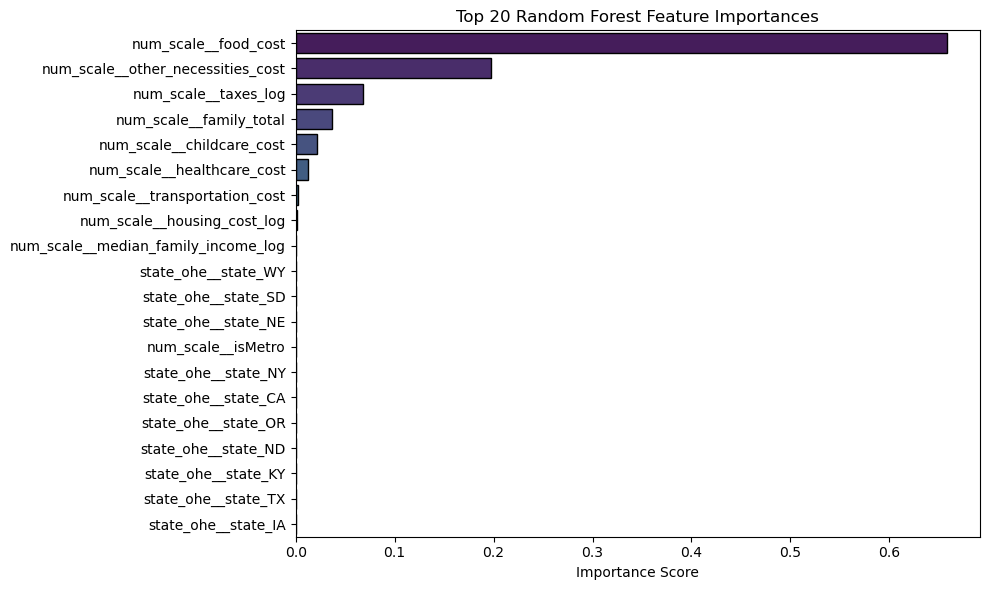

In [39]:
# Extract the raw importance vector from the fitted RandomForest
feature_importance = best_rf.feature_importances_  
#   - this is a NumPy array with one importance score per feature

# Recover the human‐readable feature names from our Pipeline
feature_names = reg_pipeline \
    .named_steps["preprocessing"] \
    .get_feature_names_out()  
#   - yields an array like ['state_ohe__state_AL', ..., 'num_scale__taxes_log', ...]

# Build a DataFrame to hold names + scores side by side
importance_rf = pd.DataFrame({
    "Feature":    feature_names,         # column of feature names
    "Importance": feature_importance     # corresponding importance scores
})

# Sort the DataFrame by descending importance
importance_rf = importance_rf.sort_values(
    by="Importance",                     # sort on the Importance column
    ascending=False                      # highest‐score first
).reset_index(drop=True)                # reset index for cleanliness

# Print the top n features so you can inspect their scores in text form
print(importance_rf.head(20))           

# Create a horizontal barplot of the top n features
plt.figure(figsize=(10, 6))             # width x height in inches
sns.barplot(
    x="Importance",                     # horizontal length = importance score
    y="Feature",                        # each bar corresponds to one feature
    data=importance_rf.head(20),        # only plot the first 20 rows
    palette="viridis",                  # color palette
    edgecolor="k"                       # black edge on each bar for clarity
)
plt.xlabel("Importance Score")          # x‐axis label
plt.ylabel("")                          # y‐axis label (features are self-evident)
plt.title("Top 20 Random Forest Feature Importances")  
plt.tight_layout()                      # adjust margins to fit labels
plt.show()                              # render the plot

**Feature Importance Results**

num_scale__food_cost (0.658707): This single feature accounts for about 66% of the model’s decision-making.
- Interpretation: Food cost is overwhelmingly the key driver in predicting total cost. In plain terms, once you know what a household spends on food (properly scaled), you can already explain most of the variation in overall cost.

num_scale__other_necessities_cost (0.197689): This feature contributes roughly 20% to the predictions.
- Interpretation: Along with food cost, spending on other necessities is the next critical component. Combined with food cost, they capture over 85% of the model’s “attention.”

num_scale__taxes_log (0.067535): Taxes, measured in a logged form, add about 6.7% importance.
- Interpretation: Differences in tax burdens matter to the overall cost—likely because tax differences can signify regulatory or economic variations across regions.

num_scale__family_total (0.036700) and num_scale__childcare_cost (0.021941): These values (3.7% and 2.2%, respectively) indicate that the total number of family members and childcare costs also play meaningful roles.
- Interpretation: They add modest explanatory power, reflecting that larger families or higher childcare costs can incrementally raise total costs.
 
The Random Forest model confirms that most of the predictive power comes from direct cost-related features, especially food and other necessities, while aspects like geography and even some supplementary costs (transportation, housing, etc.) play only minor roles. It suggests that further improvements in prediction might come from refining those dominant variables or exploring additional expense categories.

In [37]:
# Generate predictions on validation data
y_val_pred_rf = best_rf.predict(X_val_prep)

# Evaluate using your metrics function
regression_metrics(y_val, y_val_pred_rf, "RF Validation")

RF Validation Metrics:
  RMSE        = 970.10
  MAE         = 528.12
  R²          = 0.9976
  Adjusted R² = 0.9976



The RMSE value indicates that, on average, the weighted errors (which penalize larger mistakes more heavily) are around $\$970$. When compared to the median total cost of $\$70974$, this error represents roughly 1.37% of that typical cost—a very low relative error.
- A sub-2% RMSE suggests that even the larger misses are very well-contained.

MAE: At approximately $\$528$, this error is roughly 0.75% of the median cost, meaning that on a day-to-day basis, most predictions are very close to the true value.
- Achieving an MAE under 1% of the typical cost indicates a high degree of accuracy for everyday predictions.

Adjusted R-Square: The near-perfect score suggests that the model captures almost all the underlying patterns in the data. This reinforces the model’s strong explanatory power and generalization to unseen data.

Overall Assessment
- Consistency & Generalization: The low RMSE and MAE values, along with the near-perfect R-Square, indicate that the Random Forest model generalizes exceptionally well on the validation set.
- Improvement Over Lasso: Compared to the Lasso model, the Random Forest has further reduced errors, offering tighter control over both average mistakes and occasional large errors.
- Robust Performance: The strong performance across key metrics confirms that the Random Forest is capturing the crucial relationships in the data, making it an excellent candidate for your final model

In [38]:
# Predict on the held-out test set
y_test_pred_rf = best_rf.predict(X_test_prep)

# Final, unbiased performance
regression_metrics(y_test, y_test_pred_rf, "RF Test (Final)")

RF Test (Final) Metrics:
  RMSE        = 859.18
  MAE         = 513.77
  R²          = 0.9981
  Adjusted R² = 0.9981



As we can see, the model performed exceptionally well on the final test set.

# Final Evaluations

## Regression Summary

Over the course of this project, we built and compared two fundamentally different regression models: Lasso and Random Forest. Each had its own strengths.

**Lasso**:
- Lasso not only provided excellent prediction performance but also performed feature selection by zeroing out less important coefficients. This gave us a clear window into which predictors (especially direct cost components) matter most for estimating the total cost.
- With a test-set RMSE around $\$1212$ and an MAE of $\$749$ (roughly 1.7% and 1.06% of the median cost, respectively), Lasso proved to be reliable. Its near-perfect R-Square (≈0.9962) showed that almost all the variance in household cost was captured.
- The coefficient estimates highlighted that cost components like food, other necessities, and taxes were the strongest drivers of total cost. Lasso’s structure made it easy to interpret which variables hold real predictive power, even if some coefficients were small or zero.

**Random Forest**
- The Random Forest model yielded even lower error metrics, with CV RMSE figures around $\$1,003$ (and validation RMSE as low as $\$970$), and MAE around $\$572$. These improvements suggest that RF tuned its non-linear relationships very effectively.
- Although the standard deviations were slightly wider than Lasso’s, errors remained extremely low (under 2%) of the median cost. This shows that RF reliably minimizes large errors while reducing everyday prediction mistakes.
- Rather than coefficient signs, RF provides an aggregated view of “feature importance.” Here, food cost dominated the predictions (over 65% importance), followed by other necessities and taxes. This reinforced the picture that the most direct expense measures are the primary drivers behind total cost.

---

## Key Modeling Insights

**Performance Comparison:**  
- Accuracy: Random Forest delivers lower RMSE and MAE than Lasso, suggesting it better captures non-linear relationships and subtle interactions among the cost components.  
- Explained Variance: Both models attain near-perfect R-Square values, confirming that the selected features—particularly those directly measuring cost breakdown—explain virtually all variability in total cost.
   
**Interpretability vs. Flexibility:**  
- Lasso: Its built-in feature selection provides interpretability. You can see the effect size and direction (positive/negative) of each predictor. This is invaluable for explaining the determinants of household costs.  
- Random Forest: Although less directly interpretable in terms of coefficient signs, its feature importance scores and overall improved prediction metrics validate the importance of key cost drivers, even if the signal is aggregated in a black-box ensemble.

**Stability Across Data Splits:**  
- Both models featured consistent performance in cross-validation, validation, and test-set evaluations. Their error margins (RMSE and MAE as percentages of the median cost) remained within tight bands, increasing confidence in the generalization performance of your chosen models.

**Domain-Specific Insights:**  
- The overwhelming importance of direct expense inputs (like food cost and other necessities) indicates that, for the housing-cost domain, detailed and accurate measurements of everyday expenditure leave little room for hidden variance.  
- Geographic features (state dummies), while initially considered valuable, played a minimal role once core cost components were included.

---

## Key Insights on Feature Importance

**Direct Expense Components Dominate Predictions**  
- Food Cost: Both Lasso and Random Forest consistently signal that food cost carries the highest weight. In Random Forest, for example, num_scale__food_cost accounted for over 65% of the feature importance.
    - Implication: This underscores that everyday food expenses are the primary driver of overall cost. It signals that household budgets are hugely influenced by what’s spent on food, making it a crucial focus for both modeling and domain-specific intervention.  
- Other Necessities Cost: This feature emerged as the second most important predictor (around 20% importance in Random Forest and strongly weighted in Lasso's coefficients).
    - Implication:Beyond food, spending on other essential items (like utilities, basic clothing, hygiene products, etc.) plays a significant role in the total cost structure. This implies that any initiatives to manage or predict household costs must carefully account for these non-discretionary expenses.

**Moderate Influences Indicate Secondary Drivers**  
- Taxes (Logged): Taxes, transformed into logarithmic space, contribute a moderately high importance (roughly 6–7% in Random Forest).
    - Implication: Tax burdens still matter even when direct spending is considered. This suggests that local tax policies can subtly shift household financial burdens, though not as drastically as direct consumption costs.

- **Family Composition and Childcare: Features like num_scale__family_total and num_scale__childcare_cost appeared with moderate importance.
    - Implication: The size of the household and childcare expenses do affect the overall cost, albeit to a smaller extent. This indicates that economies or diseconomies of scale exist within household expenses—the more family members or higher childcare demands, the higher the total cost tends to be.

**Low Importance of Auxiliary and Geographic Variables**  
- State Dummies and Other Auxiliary Features: State indicators and certain other variables (like transportation cost, housing cost in log form) show near-negligible importance once the core expense features are included.
    - Implication: While one might expect geographic differences (such as state-specific economic conditions) to impact total cost, the models reveal that once key direct expenses are accounted for, the added value of location is minimal. This suggests that detailed personal spending captures nearly all the necessary variability in household cost.
   
**Consistency Across Modeling Approaches**  
- Observation: Despite using two different modeling strategies—Lasso (which emphasizes sparsity and interpretability) and Random Forest (which captures non-linear interactions)—the same core features (especially food cost and other necessities) repeatedly emerged as the dominant predictors.
    - Implication: This consistency bolsters our confidence in both the data quality and the modeling strategy. It tells us that irrespective of the approach, the key drivers of household cost are centered around essential consumption, and any efforts to improve prediction should start with refining these measurements.

**Overall Takeaway on Feature Engineering and Prioritization**  
- Focusing on high-quality, domain-relevant cost inputs has proven to be the most effective approach. These features not only drive the model’s predictive performance but also provide clear business or policy guidance.  
- For example, if one were to design interventions or further analyses, special attention should be paid to the determinants of food and necessity costs, as these have the most substantial impact on total household expenditure.

---

## Further Investigations

**Residual Analysis and Diagnostics:**  
- **Residual Plots:** Create scatter plots of residuals vs. predicted values to check for systematic patterns or heteroscedasticity.  
- **Normality Checks:** Use QQ-plots or histograms of residuals to assess whether the model errors align with the assumptions for further statistical analysis.

**Bootstrap and Stability Analyses for Lasso:**  
- **Coefficient Stability:** Run bootstrap resampling on the training set and refit Lasso repeatedly. Track how frequently each feature is selected and the variability of their coefficients. This can help you quantify the robustness of the feature selection.
   
**Further Feature Engineering and Interactions:**  
- **New Features:** Consider interaction terms (e.g., between housing cost and taxes) or non-linear transformations that might capture hidden patterns.  
- **Refitting with Reduced Features:** Given that Lasso zeroed out some coefficients, experiment with refitting an OLS model on only the selected features to gauge whether performance improves or remains consistent.

**Comparative Study with Other Models:**  
- While we’re stopping at two models now, keep detailed notes on model performance so that later comparisons (e.g., with gradient boosting methods like XGBoost, LightGBM, or CatBoost) can be directly juxtaposed against the baseline performance established here.
   
**Subgroup and Sensitivity Analyses:**  
- **Group-Level Errors:** Analyze error metrics across different segments (e.g., high vs. low expenditure, urban vs. rural) to see if model performance varies significantly by subgroup.
- **Sensitivity Testing:** Simulate changes in key features (for instance, a 10% increase in food cost) and study the impact on total cost predictions. This will help in understanding model responsiveness and potential policy implications.

---

## Conclusion

The comprehensive analysis using Lasso and Random Forest has provided us with multiple dimensions of understanding:

- **Lasso** offered interpretability and a clear connection between individual cost components and total spending.
- **Random Forest** delivered superior predictive accuracy by capturing non-linear relationships and interactions that Lasso could not.

Together, they reveal that the direct expense inputs dominate the prediction of total cost, while additional features, such as geographic indicators, add little unique value once these are considered. The solid performance, as evidenced by low error percentages and high R² values across all evaluations, binds the models into reliable tools for predicting housing costs.

Documenting these findings and outlining further investigation paths ensures that anyone reviewing this project—now or in the future—will clearly understand not only what was accomplished but also where the work could evolve further. This holistic closure sets a strong foundation whether you continue with ensemble methods later or refine the current models for deployment.
